# News Article Classification

We collected 241 news article from CBC News from 19th to 23rd September 2019. Each news article belongs to one of the five categories: politics, business, health, technology, or entertainment. In this notebook, our goal is to classify the news articles based on their content.

(The code for the web scraping process can be found [here](https://github.com/peterchoholam/News-Article-Classification/blob/master/cbc_scrap.py))

## Outline

1. Data Preparation
2. Exploratory Data Analysis
3. Text Classification

## Data Preparation

First of all, we will load our dataset.

In [1]:
import pandas as pd
pd.options.display.max_rows = 10

df = pd.read_csv('news.csv', index_col=0)
df

,title,content,category
0,Michigan warns about mosquito-borne virus afte...,Public health officials are urging people to g...,health
1,"Liberals pledge to boost Canada Child Benefit,...",The Liberals are promising a suite of family-f...,business
2,Hundreds join student's climate-change pledge:...,An 18-year-old McGill University student pledg...,technology
3,"Purdue Pharma, maker of OxyContin, files for b...","Purdue Pharma, the company that made billions ...",health
4,'Not one shred of scientific evidence': Critic...,When a Vancouver-area mother read a psychologi...,health
...,...,...,...
236,Greta Thunberg has talked about a 'carbon budg...,"Hello, people! This is our weekly newsletter o...",technology
237,Conservatives promise to spend $1.5B to buy ne...,Conservative Leader Andrew Scheer promised Fri...,health
238,How DNA could be key to stopping the dangerous...,As honey bee colonies across Canada continue t...,technology
239,Fighting climate change is not like fighting a...,In a personal message attached to the Green Pa...,technology


There are 241 articles in total. For each article, the dataframe contains their title, content, and category. For example, let's take a look at the first news article in our dataset. (Public health officials are urging people to g...)

In [2]:
df.iloc[0,1]

"Public health officials are urging people to guard against mosquito bites after more cases of a rare mosquito-borne virus, including two additional deaths in southwestern Michigan.  The Michigan Department of Health and Human Services issued an update Tuesday on Eastern equine encephalitis, saying there were deaths in Cass and Van Buren counties. Those follow an earlier death in Kalamazoo County.    There also have been human cases in Barry and Berrien counties, and animal cases in St. Joseph, Genesee and Lapeer counties. In all, Michigan has had seven confirmed human cases and nine horse deaths.  The department is encouraging officials in affected counties to consider postponing, rescheduling or cancelling outdoor activities occurring at or after dusk, particularly activities that involve children, until there's a hard frost.   The virus is rare but dangerous, and symptoms include fever, chills and muscle and joint pain. It can cause inflammation and swelling in the brain.   Accordin

In natural language processing, before we analyze a text, there are a few fundamental steps:
1. remove stop words, e.g. a, an, the
2. remove punctuations
3. change every word to lower case
4. lemmatize, e.g. run/runs/ran/running are considered the same

We will use the python library `spaCy` to achieve this goal.

In [3]:
import spacy
nlp = spacy.load('en')

import string
punct = [char for char in string.punctuation] # All punctuations

nlp.Defaults.stop_words.add("ll") # Add the stop word "ll" to spaCy's list of stop words
nlp.Defaults.stop_words.add("ve") # Add the stop word "ve" to spaCy's list of stop words

def cleaning(content):
    text_tokenized = [w.lemma_.lower() for w in nlp(content) # lemmatize and change to lower case
                      if w.is_stop==False # remove stop words
                      and w.text not in punct] # remove punctuations
    
    string = ""
    for word in text_tokenized:
        string = string + " " + word # collect the words to form the text again

    return string

# Apply this to every article and create a new column
df['content cleaned'] = df['content'].apply(lambda content: cleaning(content))

We can look at the article about mosquito bites again to see what's changed.

In [4]:
df.iloc[0,3]

' public health official urge people guard mosquito bite case rare mosquito bear virus include additional death southwestern michigan   michigan department health human services issue update tuesday eastern equine encephalitis say death cass van buren county follow early death kalamazoo county     human case barry berrien county animal case st. joseph genesee lapeer county michigan seven confirm human case horse death   department encourage official affect county consider postpone reschedule cancel outdoor activity occur dusk particularly activity involve child hard frost    virus rare dangerous symptom include fever chill muscle joint pain cause inflammation swell brain    accord u.s. centers disease control prevention 30 cent people infect virus die    20 case report state'

We will employ the python library `textblob` to study the polarity and subjectivity of the news near the end of our exploratory data analysis. They might not be directly related to our classification task, but they are always interesting to look at.

In [5]:
from textblob import TextBlob

df['polarity'] = df['content'].map(lambda text: TextBlob(text).sentiment.polarity)
df['subjectivity'] = df['content'].map(lambda text: TextBlob(text).sentiment.subjectivity)

## Exploratory Data Analysis

Next, we will begin our exploratory data analysis. The first thing we do is to check the distribution of the five categories.

In [6]:
pd.value_counts(df['category'])

politics         56
technology       49
business         48
health           44
entertainment    44
Name: category, dtype: int64

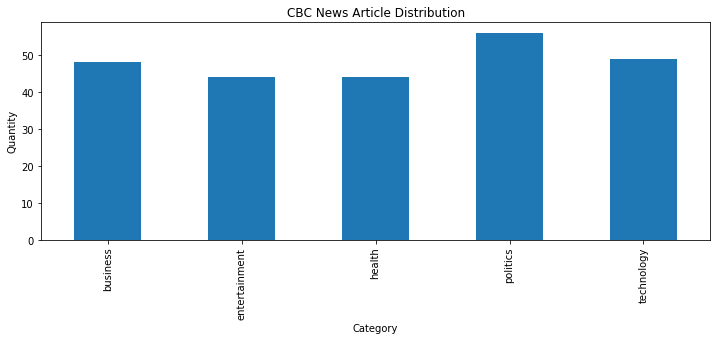

In [24]:
import matplotlib.pyplot as plt

df.groupby('category')['title'].nunique().plot(kind='bar', figsize=(12,4));
plt.ylabel('Quantity')
plt.xlabel('Category')
plt.title('CBC News Article Distribution');

We have roughly the same number of articles for each category, which is a good sign for multi-class classification problem. Unsurprisingly, the number of political news is higher since the federal election is coming!

Next, we will calculate the frequency of words in the news articles. Normally, news articles from different categories would use a very different set of vocabularies, and this is very helpful in classification.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

def words_count(category, n):
    text = df['content cleaned'][df['category']==category] # pick out a certain category
    vec = CountVectorizer(stop_words=nlp.Defaults.stop_words, ngram_range=(n,n)).fit(text)
    bag = vec.transform(text) # count the words distribution for each text
    sum_words = bag.sum(axis=0) # sum the distribution for all of the texts in that category
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()] 
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

Our function `words_count` takes two inputs. The first one is the category we want to measure (e.g. politics), and the second one is the length of the phrases we want to count. And here is our plotting function:

In [9]:
import numpy as np

def freq_plot(category, n):
    label, value = zip(*words_count(category, n)[:15])
    index = np.arange(len(label))
    plt.figure(figsize=(12,5))
    plt.bar(index, value)
    plt.ylabel('Frequency')
    plt.xlabel('Words')
    plt.xticks(index, label, fontsize=12, rotation=60)
    plt.title('The 15 most frequent words/phrases with length ' + str(n) + ' (' + category + ')');

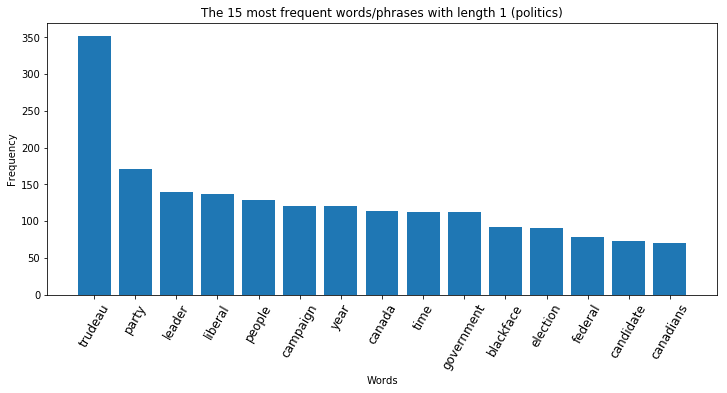

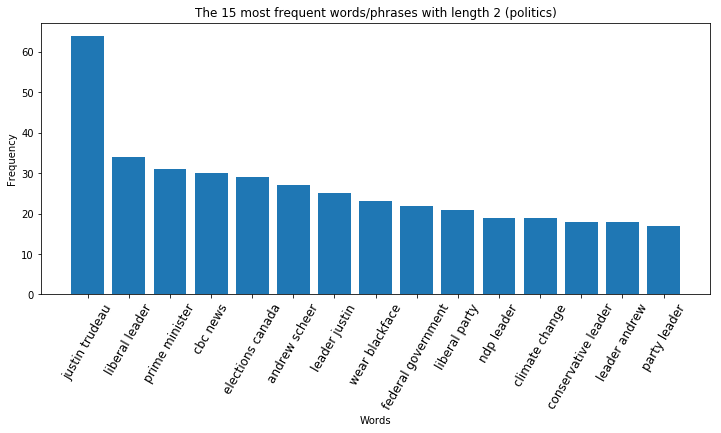

In [10]:
freq_plot('politics', 1) # 15 most frequent words in politics
freq_plot('politics', 2) # 15 most frequent phrases/2-grams in politics

As the Canadian federal election is getting closer, the leaders of various political parties come up a lot in the charts (e.g. Justin Trudeau, Andrew Scheer). The word "trudeau" alone already appeared around 350 times. The recent "blackface" scandal of Trudeau has drawn a lot of attention. The above statistics might worry the New Democratic Party (NDP), as they barely get any news coverage.

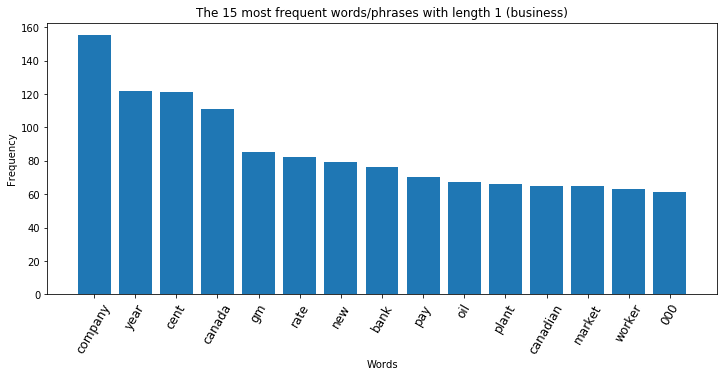

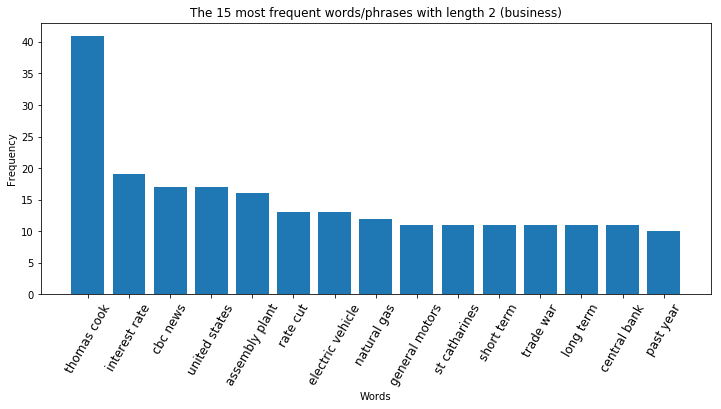

In [11]:
freq_plot('business', 1) # 15 most frequent words in business
freq_plot('business', 2) # 15 most frequent phrases/2-grams in business

The sudden bankruptcy of the British travel operator Thomas Cook is probably the biggest news right now. By the way, the popular word "gm" refers to General Motors, a company in the United States and there is an ongoing strike since last week.

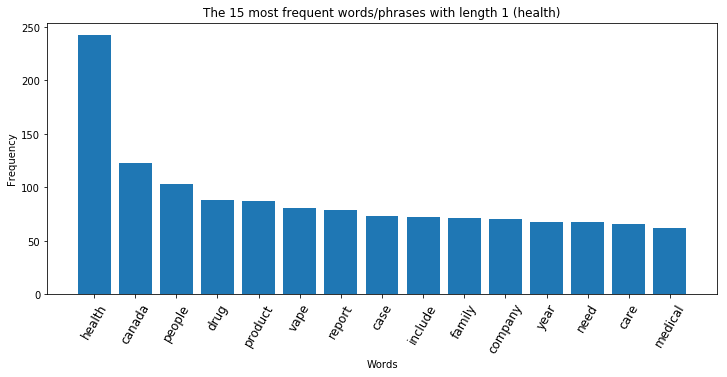

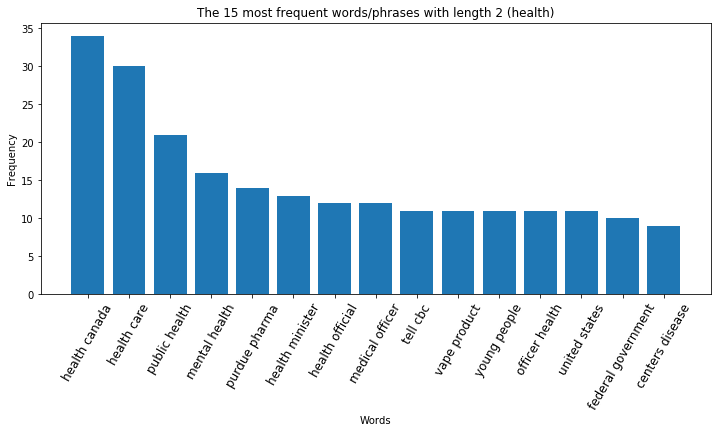

In [12]:
freq_plot('health', 1) # 15 most frequent words in business
freq_plot('health', 2) # 15 most frequent phrases/2-grams in health

There is a general interest in public health issues, which is understandable since the election is due next month and public health policy is an important aspect of the platforms.

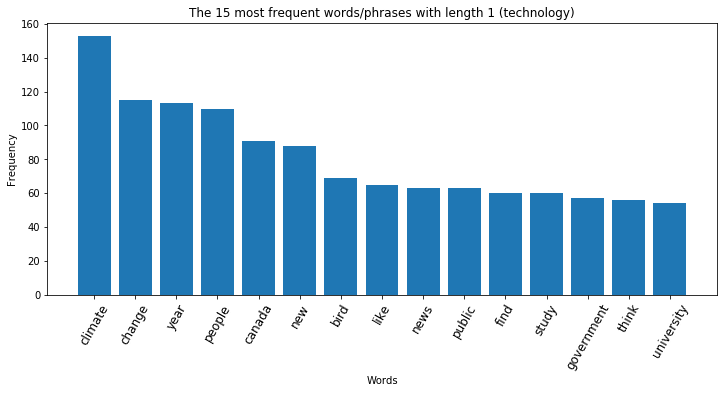

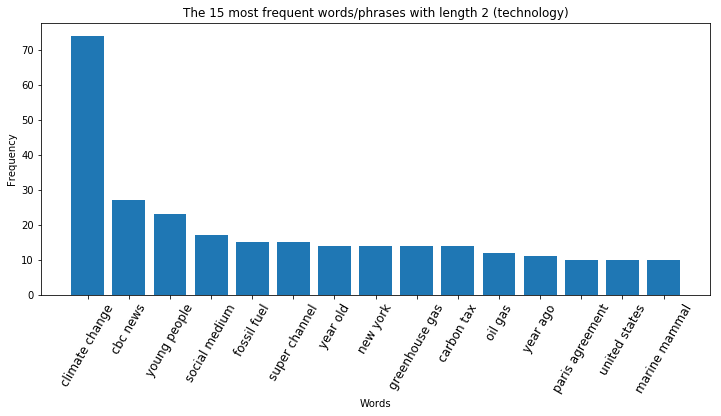

In [13]:
freq_plot('technology', 1) # 15 most frequent words in technolog
freq_plot('technology', 2) # 15 most frequent phrases/2-grams in technology

Climate change is certainly a hot topic as the Global Climate Strike is happening now.

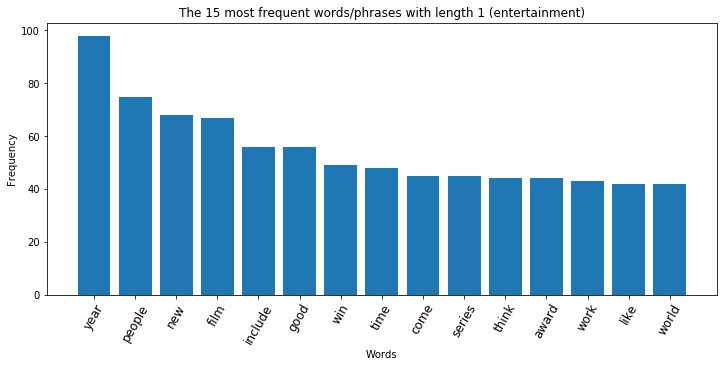

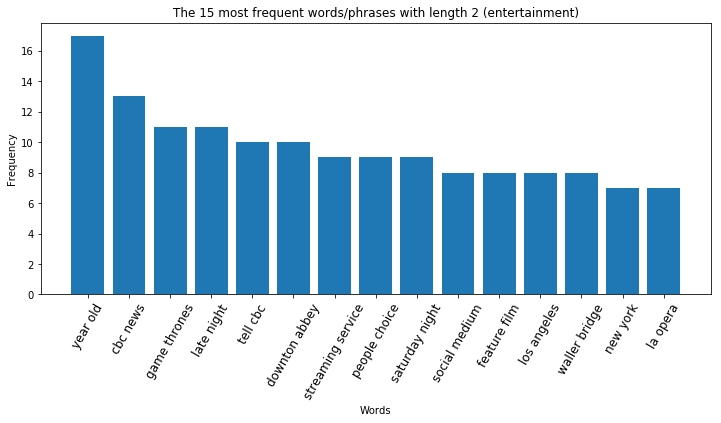

In [14]:
freq_plot('entertainment', 1) # 15 most frequent words in entertainment
freq_plot('entertainment', 2) # 15 most frequent phrases/2-grams in entertainment

Interestingly, in the first chart, there is no name-entity at all.

Next, we look at the polarity measure. It is a number between 1 and -1. It indicates whether the news article is presenting a positive or negative message.

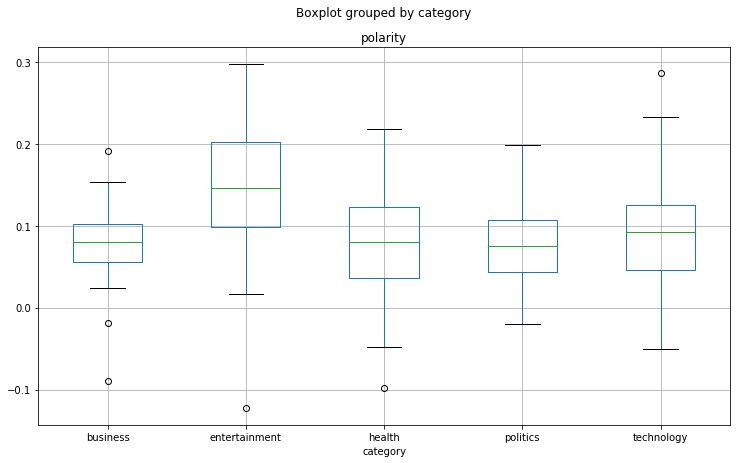

In [15]:
fig, ax = plt.subplots(figsize=(12,7))
df.boxplot(column='polarity', by='category', ax=ax);

From the graph, we can see that all the articles are essentially neutral. The most positive and the most negative articles are both from entertainment. But still, they are very close to 0.

We can take a look at the most "positive" article:

In [16]:
polarity_max = df['polarity'].max()
id_polarity_max = df.index[df['polarity']==polarity_max].tolist()[0]
df.iloc[id_polarity_max, 1]

"Netflix says it will start streaming all 180 episodes of Seinfeld in 2021, gaining a hugely popular addition to its library as the battle for viewers heats up.  Netflix Inc. struck the deal with Sony Pictures Television for the global streaming rights to the Emmy-winning television comedy, which aired its final episode in 1998.    Terms were not released.  Netflix is also the home of Jerry Seinfeld's talk series Comedians in Cars Getting Coffee.    The deal for Seinfeld comes after Netflix announced in June that it would be losing its most popular TV show, The Office.   Netflix will still carry the show for more than a year, but NBC isn't extending the licence further with NBCUniversal's streaming service launching in 2020.    Netflix will face even more competition in November, when Apple and Disney launch their own streaming services within days of each other."

And here is the most "negative" article:

In [17]:
polarity_min = df['polarity'].min()
id_polarity_min = df.index[df['polarity']==polarity_min].tolist()[0]
df.iloc[id_polarity_min, 1]

'Liberal Leader Justin Trudeau got the wrong kind of international attention overnight as talk show hosts took jabs at him for dressing in brown- and blackface.  A photo from a 2001 yearbook shows Trudeau dressed as Aladdin at an "Arabian Nights"-themed event at a Vancouver private school where he taught.  In the photo, Trudeau is clad in a turban and robe with his face, hands and neck covered in dark makeup.  As part of his opening segment, The Daily Show host Trevor Noah joked that Trudeau didn\'t even get the skin colour right for Aladdin.  He said — quote — "Trudeau isn\'t dressed as Aladdin, he\'s dressed as Aladdin doing blackface."    American talk-show host Stephen Colbert also mentioned the photo, calling it "really bad."  And Late Night host Seth Meyers said the photo is — quote — "so bad that Canadians travelling in Europe are going to start telling people they\'re American."'

The news is about Trudeau's blackface scandal.

How about subjectivity? It will be a number between 0 and 1, and 1 means the news is very subjective. So let see.

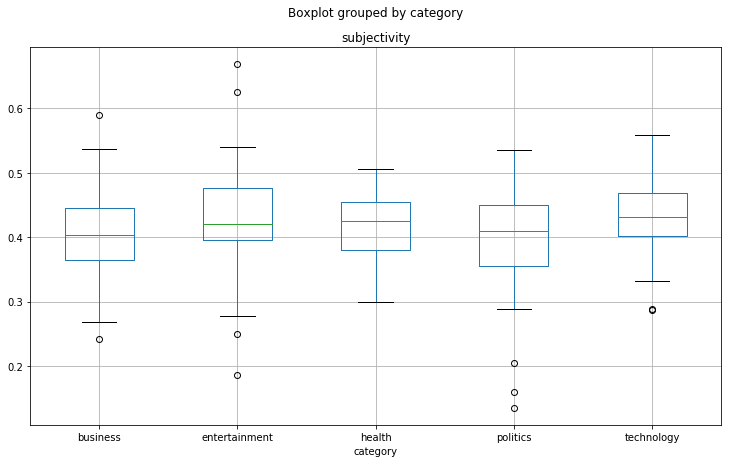

In [18]:
fig, ax = plt.subplots(figsize=(12,7))
df.boxplot(column='subjectivity', by='category', ax=ax);

It turns out that most CBC News articles are quite objective. There are a few articles from politics that are quite near 0. This time, let's look at the most objective news here:

In [19]:
subjectivity_min = df['subjectivity'].min()
id_subjectivity_min = df.index[df['subjectivity']==subjectivity_min].tolist()[0]
df.iloc[id_subjectivity_min, 1]

"Here's what you need to know about where the leaders of Canada's political parties are on Day 13 of the election campaign.  You can watch streaming video of available live events on this page throughout the day.  All times are Eastern Time unless otherwise noted.          Green Party Leader Elizabeth May:     12 p.m. (1 p.m. local) Announcement in Fredericton.   12:30 p.m. (1:30 p.m. local) Green Party rally in Fredericton.   3:30 p.m. (4:30 p.m. local) Campaign office visit in Moncton.   6:30 p.m. (7:30 p.m. local) Green Party rally in Charlottetown.    NDP Leader Jagmeet Singh:     9:30 a.m. (10:30 a.m. local) Announcing candidate in Bathurst, N.B.   2:35 p.m. (3:35 p.m. local) Mainstreeting with city councillor Lindell Smith in Halifax.   3 p.m. (4 p.m. local) Town hall event on health care in Halifax.      Conservative Leader Andrew Scheer:     10 a.m. Announcement and media availability in Markham, Ont.   2:30 p.m. Visit to a seniors' home in St. Catharines, Ont.   6 p.m. Campaig

Everything in here is plain fact. No wonder it is considered to be objective!

In [20]:
subjectivity_max = df['subjectivity'].max()
id_subjectivity_max = df.index[df['subjectivity']==subjectivity_max].tolist()[0]
df.iloc[id_subjectivity_max, 1]

"It's no joker. The night was lighting up around the world Saturday with the famous bat signal to mark a special anniversary for Batman.  DC Comics carried off a celebration of Batman Day to mark the 80th anniversary of the appearance of crimefighter Bruce Wayne and his masked identity.  Fan gatherings happened all over the world. But the most ambitious party plan was the illumination of the bat signal.  It started at Fed Square in Melbourne, Australia. It was also planned to appear in 13 other cities, including Montreal Tokyo, Berlin, Rome, Paris, London, Sao Paulo and Johannesburg.  In the U.S., it was to light up at the Domino Sugar Refinery in New York City before making its final appearance in Los Angeles at City Hall."

This article contains words like "famous", "special", and "ambitious". This is perhaps the reason why this article is on the subjective side.

Now we are ready to train various machine learning models and carry out our predictions. The exploratory data analysis shows that the five categories used very different kind of words indeed, and this is a good sign for text classification. However, the size of our dataset is relatively small, so there is a limit on what we can do.

Remark: if we use the stop words from sklearn (instead of from spaCy), the word "said" will remain and become the champion of most graphs above. This is probably because CBC News quoted a lot of people.

## Text Classification

We will employ three different models: logistic regression, support vector machine, and random forest.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer # a weighted frequency counter
from sklearn.pipeline import Pipeline

tfidf_vector = TfidfVectorizer(stop_words=nlp.Defaults.stop_words, ngram_range=(1,2))

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

logit_classifier = LogisticRegression(solver='lbfgs', multi_class='auto')
svm_classifier = SVC(kernel='linear', gamma='scale') # default kernel is rbf, but it is not effective here
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=0)

pipe_logit = Pipeline([('vectorizer', tfidf_vector),
                ('classifier', logit_classifier)])

pipe_svm = Pipeline([('vectorizer', tfidf_vector),
                ('classifier', svm_classifier)])

pipe_rf = Pipeline([('vectorizer', tfidf_vector),
                ('classifier', rf_classifier)])

For each model, we will perform a 5-fold cross-validation.

In [23]:
from sklearn.model_selection import cross_val_score

X = df['content cleaned']
y = df['category']

scores = cross_val_score(pipe_logit, X, y, cv=5)
print("Accuracy using logistic regression: " + str(np.mean(scores)))

scores = cross_val_score(pipe_svm, X, y, cv=5)
print("Accuracy using support vector machine: " + str(np.mean(scores)))

scores = cross_val_score(pipe_rf, X, y, cv=5)
print("Accuracy using random forest: " + str(np.mean(scores)))

Accuracy using logistic regression: 0.7815963718820862
Accuracy using support vector machine: 0.8226156462585035
Accuracy using random forest: 0.7724557823129252


They all achieve around 80% accuracy for this text classification problem. This is quite impressive since our dataset is really small (241 articles, collected in a week)! Furthermore, the five categories are not mutually exclusive - for example, there might be a news article on the health care policy of the liberal party in the politics section, but our model might put it under the health section.

So thank you for reading! If you have any comment on how this notebook can be improved, please let me know.